In [ ]:
from google.colab import drive
drive.mount(f'/content/drive')
%cd 'drive/MyDrive/BDP_Final_Project'

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

Mounted at /content/drive
/content/drive/MyDrive/BDP_Final_Project
--2023-02-13 17:22:16--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M  54.7MB/s    in 5.0s    

2023-02-13 17:22:21 (57.6 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/R

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, StringType, BooleanType, FloatType
from pyspark.sql.functions import udf, col, month, hour
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import count, desc, when, col, lit, sum
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import os, findspark
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import desc, col, count
from pyspark.sql.window import Window
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_date, to_utc_timestamp, to_timestamp
from sklearn.cluster import KMeans
from scipy.stats import norm

warnings.filterwarnings('ignore')

In [ ]:
spark = SparkSession.builder.appName('treatmeant').getOrCreate()

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
findspark.init()

In [ ]:
def remove_old_data(df, start_year='2022', end_year='2023'):
  """
    a pre processing function which is used to remove data which is before 2022
    and after 2023
  """
  df = df.withColumn("Date", to_timestamp(df["OCCURRED ON"], "MM/dd/yyyy  HH:mm"))
  start_date = lit(start_year + "-01-01").cast(TimestampType())
  end_date = lit(end_year + "-01-01").cast(TimestampType())
  df = df.filter(col('Date') >= start_date)
  return df.filter(col('Date') <= end_date)

def remove_redundant_columns(df, needed_columns):
  """
    a pre processing function which deletes not needed columns (such that do not
    help us - like ID, Names etc...)
  """
  
  df = df.select([col for col in df.columns if col in needed_columns])
  return df.dropna(how='any')

from pyspark.ml.clustering import KMeans
def add_columns_to_group_from(df, k=20):
  """
    this function is used to divide the geographical locations to 20 different area,
    by the avenue number
  """
  # Define a UDF to perform the split operation on a string
  split_udf = udf(lambda row: row.split('XX')[0], StringType())
  df = df.withColumn("AVE Number", split_udf(df["100 BLOCK ADDR"]))
  top_20_block_addrs = df.groupBy("AVE Number").count().sort(desc("count")).limit(20).rdd.map(lambda row: row["AVE Number"]).collect()
  df = df.filter(df["AVE Number"].isin(top_20_block_addrs))
  
  df = df.withColumn("Month", month(col("Date")))
  df = df.withColumn("Hour", hour(col("Date")))
  
  def daily_type_setter(hour):
    """
      this function is used to split the day for morning, evening and night
    """
    if 4 <= hour < 12:
      return 'Morning'
    elif 12 <= hour < 20:
      return 'Evening'
    else:
      return 'Night'
      
  daily_type_setter_udf = udf(daily_type_setter, StringType())
  df = df.withColumn("Hour Type", daily_type_setter_udf(col("Hour")))
  
  return df


def plot_top_10_primary_type_probabilities(df, baseline_column, against_column):
    """
      this function is used to plot a heatmap of the probabilities of crimes,
      in a given manner
    """
    # Get the top 10 values in Primary Type that occurred the most
    top_10_primary_types = df.groupBy(baseline_column).count().sort("count", ascending=False).limit(10).select(baseline_column).rdd.flatMap(lambda x: x).collect()

    # Filter the data to only include the top 10 values in Primary Type
    df = df.filter(df[baseline_column].isin(top_10_primary_types))

    # Calculate the probabilities of each value in Primary Type for each month
    primary_type_counts = df.groupBy([baseline_column, against_column]).count().sort("count", ascending=False)

    # Plot the probabilities of each value in Primary Type for each month
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(primary_type_counts.toPandas().pivot(index=against_column, columns=baseline_column, values='count').apply(lambda x: x/x.sum(), axis=1), cmap="YlGnBu", annot=True, fmt='.2f', ax=ax)
    ax.set_title(f'Probabilities of each value in {baseline_column} (Top 10) for each {against_column}')
    ax.set_xlabel('Crimes')
    ax.set_ylabel(against_column)
    plt.show()

def plot_top_10_primary_type_occurrences_by_column(df, baseline_column, column):
    """
      this function is used to plot the occurrences of all the crimes given a specific
      manner
    """
    # Count the occurrences of each value in the Primary Type column
    primary_type_counts = df.groupBy(baseline_column).agg(count("*").alias("count"))\
                           .sort(desc("count"))

    # Keep only the top 10 values
    top_10_primary_types = primary_type_counts.limit(10).rdd.map(lambda row: row[baseline_column]).collect()
    
    # Filter the dataframe to include only the top 10 values in the Primary Type column
    df_top_10 = df.filter(col(baseline_column).isin(top_10_primary_types))

    # Create a pivot table to count the occurrences of each value in the Primary Type column for each value in the checked column
    pivot_table = df_top_10.groupBy(column, baseline_column).agg(count("*").alias("count"))\
                        .groupBy(column).pivot(baseline_column).agg(sum("count"))

    # Plot the pivot table as bar plots using seaborn
    plt.figure(figsize=(10,5))
    sns.barplot(data=pivot_table.toPandas())
    plt.title(f'Occurrences of the top 10 values in {baseline_column} for each value in {column}')
    plt.xlabel('Crimes')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

import pandas as pd
def plot_top_10_variances(df, baseline_column, columns):
    """
      this function is used to plot the variances of each crime given a manner
    """
    primary_type_counts = df.groupBy(baseline_column).agg(F.count("*").alias("count"))
    top_10_primary_types = primary_type_counts.sort(F.desc("count")).limit(10).rdd.map(lambda row: row[baseline_column]).collect()
    df_top_10 = df.filter(df[baseline_column].isin(top_10_primary_types))
    variances_df = pd.DataFrame(columns=columns)
    for column in columns:
        pivot_table = df_top_10.groupBy(column, baseline_column).agg(F.count("*").alias("count"))
        pivot_table = pivot_table.groupBy(column).pivot(baseline_column).agg(F.mean("count"))

        for col in top_10_primary_types:
            min_val = pivot_table.agg(F.min(col)).collect()[0][0]
            max_val = pivot_table.agg(F.max(col)).collect()[0][0]
            pivot_table = pivot_table.withColumn(col, (pivot_table[col] - min_val) / (max_val - min_val))
        
        variances = list(pivot_table.toPandas().var(axis=0))
        if len(variances) != len(top_10_primary_types):
            variances = variances[1:]

        variances_df[column] = variances

    variances_df.index = top_10_primary_types
    return variances_df


#Loading The Data

In [ ]:
schema = StructType([
    StructField("INC NUMBER", StringType()),
    StructField("OCCURRED ON", StringType()),
    StructField("OCCURRED TO", StringType()),
    StructField("UCR CRIME CATEGORY", StringType()),
    StructField("100 BLOCK ADDR", StringType(), True),
    StructField("ZIP", StringType(), True),
    StructField("PREMISE TYPE", StringType(), True),
    StructField("GRID", StringType(), True)])


df = spark.read.csv('phoenix_crimes.csv', schema=schema, header=True)
df = df.filter(col("UCR CRIME CATEGORY") != "LARCENY-THEFT")
df.show(5)

+---------------+-----------------+-----------------+-------------------+--------------------+-----+-------------------+-----+
|     INC NUMBER|      OCCURRED ON|      OCCURRED TO| UCR CRIME CATEGORY|      100 BLOCK ADDR|  ZIP|       PREMISE TYPE| GRID|
+---------------+-----------------+-----------------+-------------------+--------------------+-----+-------------------+-----+
|202300000214939|12/05/2022  00:00|             null|MOTOR VEHICLE THEFT|     174XX N 42ND LN|85308|SINGLE FAMILY HOUSE| DH19|
|202300000212038|01/04/2023  00:00|02/10/2023  00:00|               RAPE|    26XX E PIERCE ST|85008|           HOSPITAL| BB33|
|202300000211440|02/03/2023  00:00|             null|               RAPE|     77XX S 71ST AVE|85339|            UNKNOWN| IB12|
|202300000209777|01/29/2023  20:00|01/30/2023  08:00|MOTOR VEHICLE THEFT|26XX E FAIRMOUNT AVE|85016|SINGLE FAMILY HOUSE| BG33|
|202300000209680|10/15/2022  00:00|10/17/2022  19:00|               RAPE|36XX N BLACK CANY...|85015|SINGLE FAMI

#Pre Processing

In [ ]:
df = remove_redundant_columns(df, needed_columns=['OCCURRED ON', 'UCR CRIME CATEGORY', '100 BLOCK ADDR', 'PREMISE TYPE'])
df = remove_old_data(df)
df = add_columns_to_group_from(df)
df.show(5)

+-----------------+------------------+--------------------+--------------------+-------------------+----------+-----+----+---------+
|      OCCURRED ON|UCR CRIME CATEGORY|      100 BLOCK ADDR|        PREMISE TYPE|               Date|AVE Number|Month|Hour|Hour Type|
+-----------------+------------------+--------------------+--------------------+-------------------+----------+-----+----+---------+
|10/15/2022  00:00|              RAPE|36XX N BLACK CANY...| SINGLE FAMILY HOUSE|2022-10-15 00:00:00|        36|   10|   0|    Night|
|09/15/2022  00:00|          BURGLARY|    34XX W GRAND AVE|           APARTMENT|2022-09-15 00:00:00|        34|    9|   0|    Night|
|12/01/2022  00:00|          BURGLARY|23XX W INDIAN SCH...|RENTAL STORAGE / ...|2022-12-01 00:00:00|        23|   12|   0|    Night|
|10/01/2022  00:00|          BURGLARY|  22XX W MCDOWELL RD|RENTAL STORAGE / ...|2022-10-01 00:00:00|        22|   10|   0|    Night|
|11/28/2022  17:30|AGGRAVATED ASSAULT|      22XX E BELL RD|     RETAI

#Feature Importance - Decision Tree

In [ ]:
df['AVE Number'].schema

Column<'AVE Number[schema]'>

In [ ]:
def get_features_importance(df, categorical_columns=["Hour Type"], numeric_columns=["Hour", "Month", "Geo Type"], target_col='OFFENSE_DESCRIPTION'):
  """
    this function is used to check the importance of each feature we check, 
    while trying to predict crimes.
  """
  
  categorical_columns = categorical_columns
  numeric_columns = numeric_columns
  indexers = [
      StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep')
      for c in categorical_columns]

  encoders = [OneHotEncoder(dropLast=False,inputCol=f"{c}_indexed", outputCol=f"{c}_encoded")
              for c in categorical_columns]

  assembler = VectorAssembler(inputCols = numeric_columns + [f"{c}_encoded" for c in categorical_columns], outputCol="features", handleInvalid='keep')
  class_indexer = StringIndexer(inputCol=target_col, outputCol='CLASS_indexed', handleInvalid='skip')
  dt = DecisionTreeClassifier(labelCol="CLASS_indexed", featuresCol="features")

  (trainingData, testData) = df.randomSplit([0.7, 0.3])

  # Train the decision tree model
  new_data = indexers[0].fit(df).transform(df)

  for indexer in indexers[1:]:
      new_data = indexer.fit(new_data).transform(new_data)

  for encoder in encoders:
      new_data = encoder.fit(new_data).transform(new_data)

  new_data = new_data.drop('features')
  new_data = new_data.withColumn("AVE Number", col("AVE Number").cast("int"))

  new_data = assembler.transform(new_data)
  new_data = class_indexer.fit(new_data).transform(new_data).select('features', 'CLASS_indexed')

  model = dt.fit(new_data)
  importances = model.featureImportances
  feature_importances = {assembler.getInputCols()[i]: importances[i] for i in range(len(assembler.getInputCols()))}
  for feature, imp in feature_importances.items():
    print(f"The importance of {feature}: {imp} ")

get_features_importance(df, categorical_columns=["Hour Type"], numeric_columns=["Hour", "Month", "AVE Number"], target_col='UCR CRIME CATEGORY')

The importance of Hour: 0.38371224333678877 
The importance of Month: 0.14007544799063923 
The importance of AVE Number: 0.4189344079143988 
The importance of Hour Type_encoded: 0.0 


#Analysis and Visualization

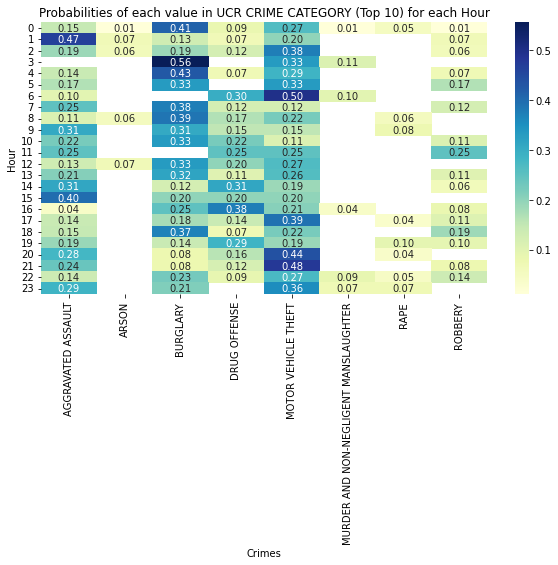

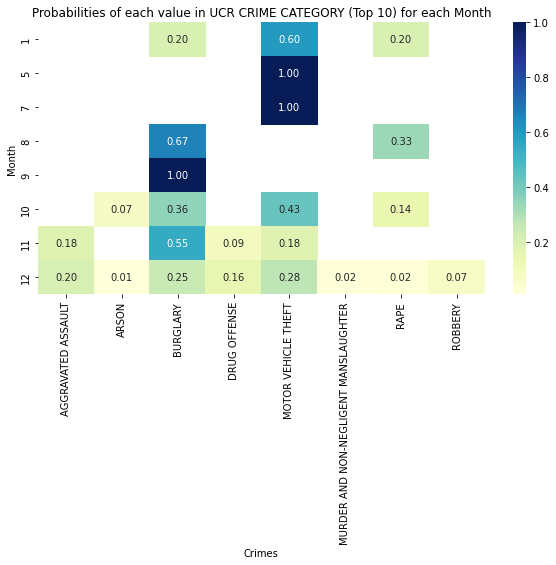

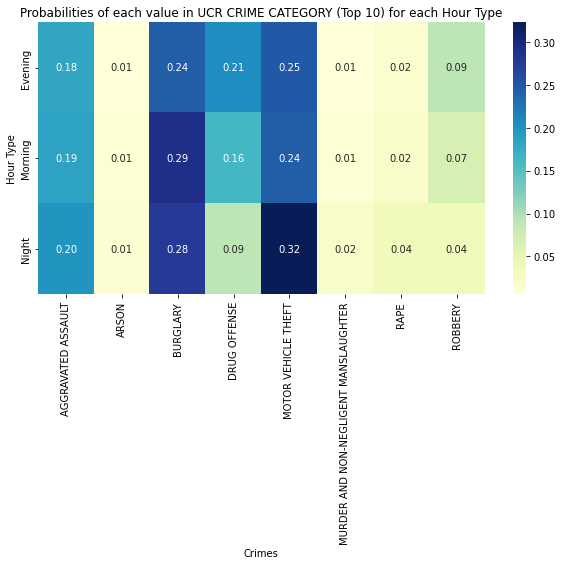

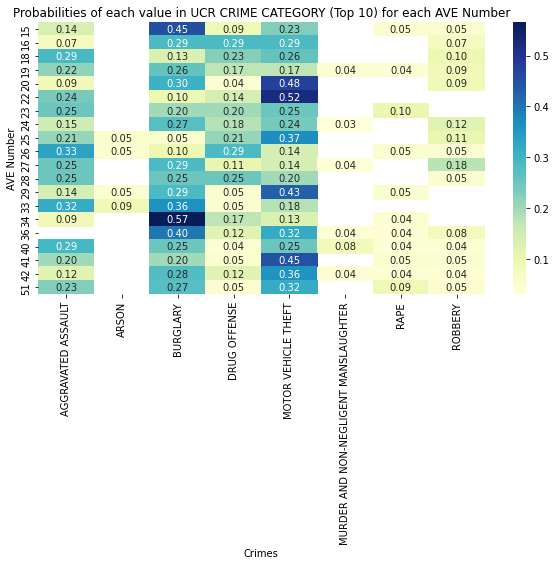

In [ ]:
for column in ['Hour', 'Month', 'Hour Type', 'AVE Number']:
  plot_top_10_primary_type_probabilities(df, baseline_column='UCR CRIME CATEGORY', against_column=column)

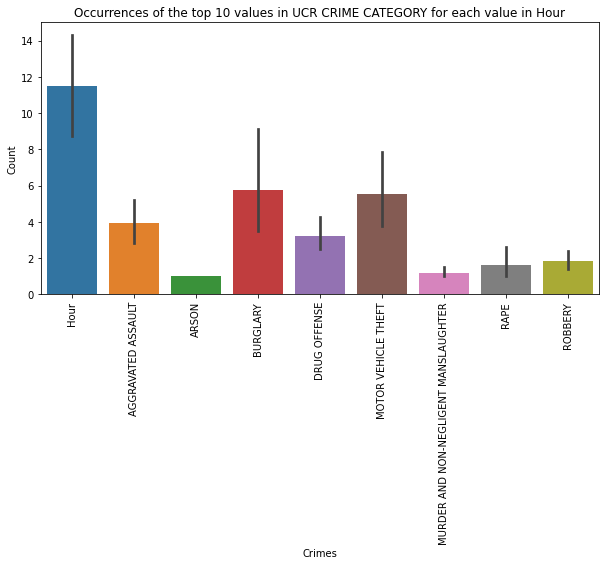

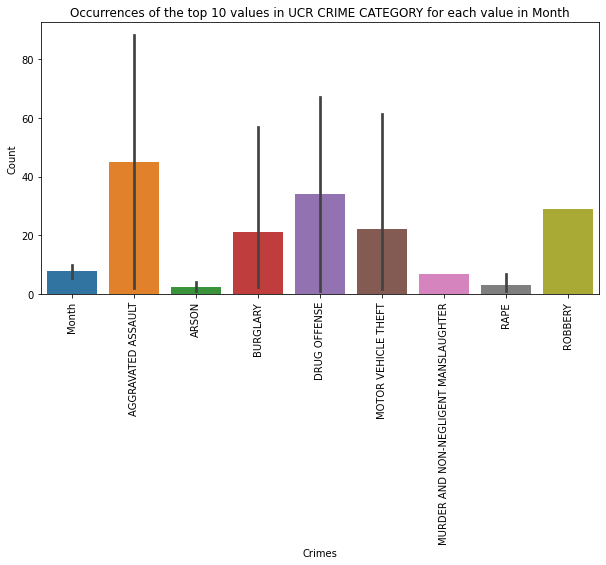

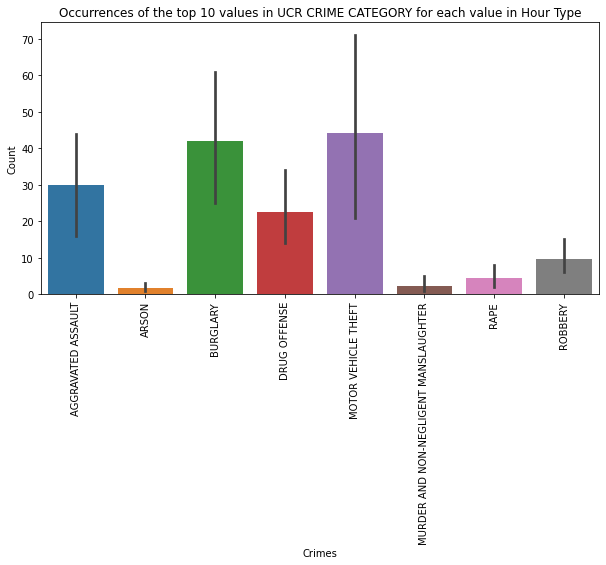

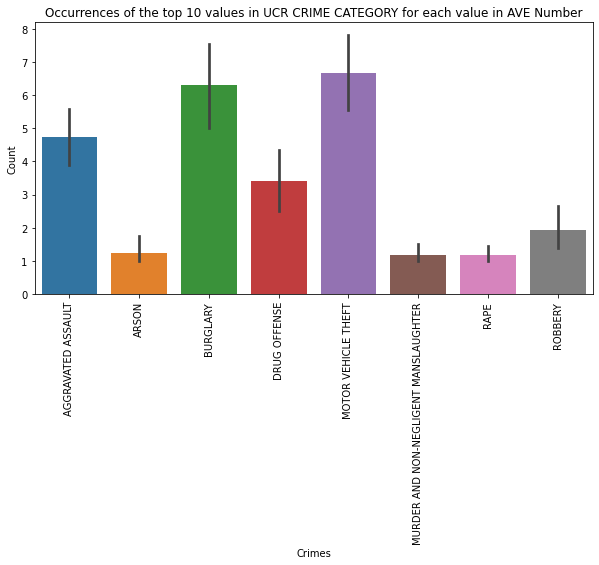

In [ ]:
for column in ['Hour', 'Month', 'Hour Type', 'AVE Number']:
  plot_top_10_primary_type_occurrences_by_column(df, baseline_column='UCR CRIME CATEGORY', column=column)

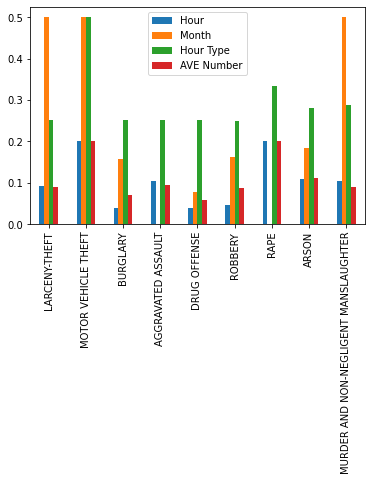

In [ ]:
variances_df = plot_top_10_variances(df, baseline_column='UCR CRIME CATEGORY', columns=['Hour', 'Month', 'Hour Type', 'AVE Number'])
variances_df.plot.bar()
